In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
from tqdm import tqdm
# from tqdm.notebook import tqdm as tqdm
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
from tsai.all import *

torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False
torchaudio.set_audio_backend('soundfile')
import os
import random
from pathlib import Path

import matplotlib.pyplot as plt
import psutil
import requests

from utils import *
from wingbeat_datasets import *
from wingbeat_models import *

print(f'Total RAM      : {bytes2GB(psutil.virtual_memory().total):5.2f} GB')
print(f'Available RAM  : {bytes2GB(psutil.virtual_memory().available):5.2f} GB\n')

/home/kalfasyan/anaconda3/envs/wbai/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


Available workers: 16
Total RAM      : 31.21 GB
Available RAM  : 23.20 GB



In [3]:
num_epochs = 35
batch_size = 32
batch_size_val = batch_size * 2
validation_split = .2
shuffle_dataset = True
num_workers = psutil.cpu_count()
random_seed= 42
setting = 'raw'

In [25]:
transforms_list = [FilterWingbeat(setting='bandpass'), Normalize()]
dmel1 = WingbeatsDataset(dsname="Melanogaster_RL/Y", custom_label=[0], transform=transforms.Compose(transforms_list)).clean()
dmel2 = WingbeatsDataset(dsname="Melanogaster_RL/Z", custom_label=[0], transform=transforms.Compose(transforms_list)).clean()
dsuz1 = WingbeatsDataset(dsname="Suzukii_RL/L",      custom_label=[1], transform=transforms.Compose(transforms_list)).clean()
dsuz2 = WingbeatsDataset(dsname="Suzukii_RL/R",      custom_label=[1], transform=transforms.Compose(transforms_list)).clean()

Found 29002 in dataset: Melanogaster_RL/Y, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]
Nr. of valid wingbeats: 12819
Found 24763 in dataset: Melanogaster_RL/Z, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]
Nr. of valid wingbeats: 11778
Found 21940 in dataset: Suzukii_RL/L, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]
Nr. of valid wingbeats: 14729
Found 14348 in dataset: Suzukii_RL/R, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]
Nr. of valid wingbeats: 10372


In [26]:
transformed_dataset = ConcatDataset([dmel1, dsuz1])

train_size = int(0.8 * len(transformed_dataset))
valid_size = len(transformed_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(transformed_dataset, [train_size, valid_size])
test_dataset = ConcatDataset([dmel2, dsuz2])

In [27]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size_val, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, num_workers=num_workers)

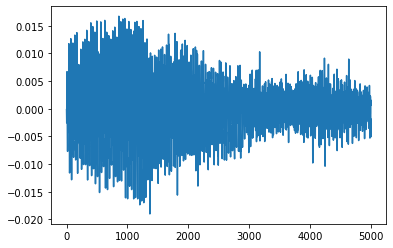

In [28]:
from IPython.display import Audio
sig = train_dataset[9][0]
plt.plot(sig.T)
Audio(sig, rate=8000, autoplay=True)

In [7]:
if setting.startswith('psd'):
    model = Conv1dNetPSD()
else:
    if modeltype == 'raw':
#     model = Conv1dNetRAW()
    elif modeltype == 'inception':
        model = nn.Sequential(
                        InceptionBlock(
                            in_channels=1, 
                            n_filters=32, 
                            kernel_sizes=[5, 11, 23],
                            bottleneck_channels=32,
                            use_residual=True,
                            activation=nn.ReLU()
                        ),
                        InceptionBlock(
                            in_channels=32*4, 
                            n_filters=32, 
                            kernel_sizes=[5, 11, 23],
                            bottleneck_channels=32,
                            use_residual=True,
                            activation=nn.ReLU()
                        ),
                        nn.AdaptiveAvgPool1d(output_size=1),
                        Flatten(out_features=32*4*1),
                        nn.Linear(in_features=4*32*1, out_features=2))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
early_stopping = EarlyStopping(patience=7, verbose=1)
# print(model)

In [8]:
# list(model.children())[0]

In [13]:
# test if everything works with mock input
# import torchsummary
# torchsummary.summary(model, (1,10000))
# x = torch.randn(32, 1, 5000)

# output = model(x)
# output

## Training

In [11]:
# Choosing whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')# Number of gpus
model = model.to('cuda', dtype=torch.float)

# Model training
for epoch in range(num_epochs):
    # Going through the training set
    correct_train = 0
    model.train()
    for x_batch,y_batch,path_batch,idx_batch in tqdm(train_dataloader, desc='Training..\t'):        

        y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
        x_batch,y_batch = x_batch.cuda(), y_batch.cuda()
        
        optimizer.zero_grad()
        pred = model(x_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
        correct_train += (pred.argmax(axis=1) == y_batch).float().sum().item()

    train_accuracy = correct_train / (len(train_dataloader)*batch_size) * 100.
    # Going through the validation set
    correct_valid = 0
    model.eval()
    for x_batch,y_batch,path_batch,idx_batch in tqdm(valid_dataloader, desc='Validating..\t'):
        
        y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
        x_batch,y_batch = x_batch.cuda(), y_batch.cuda()

        pred = model(x_batch)
        val_loss = criterion(pred, y_batch)
        correct_valid += (pred.argmax(axis=1) == y_batch).float().sum().item()
    valid_accuracy = correct_valid / (len(valid_dataloader)*batch_size_val) * 100.
    scheduler.step(val_loss)
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

        # Printing results
    print(f"Epoch {epoch}: train_acc: {train_accuracy:.2f}% loss: {loss:.3f},  val_loss: {val_loss:.3f} val_acc: {valid_accuracy:.2f}%")


Train on gpu: True


Training..	:   0%|          | 0/689 [00:00<?, ?it/s]

Validation loss decreased (inf --> 1.203017).  Saving model ...
Epoch 0: train_acc: 82.18% loss: 0.483,  val_loss: 1.203 val_acc: 72.04%


Training..	:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 1: train_acc: 85.55% loss: 0.358,  val_loss: 8.086 val_acc: 51.99%


Training..	:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 2: train_acc: 86.91% loss: 0.316,  val_loss: 12.143 val_acc: 51.99%


Training..	:   0%|          | 0/689 [00:00<?, ?it/s]

Validation loss decreased (1.203017 --> 0.768829).  Saving model ...
Epoch 3: train_acc: 87.66% loss: 0.295,  val_loss: 0.769 val_acc: 61.93%


Training..	:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 4: train_acc: 88.14% loss: 0.292,  val_loss: 2.067 val_acc: 52.08%


Training..	:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 5: train_acc: 88.71% loss: 0.282,  val_loss: 3.255 val_acc: 52.03%


Training..	:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 6: train_acc: 89.43% loss: 0.261,  val_loss: 4.044 val_acc: 52.07%


Training..	:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch     8: reducing learning rate of group 0 to 1.0000e-03.
Epoch 7: train_acc: 90.09% loss: 0.219,  val_loss: 29.297 val_acc: 51.99%


Training..	:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 8: train_acc: 92.69% loss: 0.175,  val_loss: 1.387 val_acc: 76.56%


Training..	:   0%|          | 0/689 [00:00<?, ?it/s]

Validation loss decreased (0.768829 --> 0.696883).  Saving model ...
Epoch 9: train_acc: 93.49% loss: 0.178,  val_loss: 0.697 val_acc: 92.35%


Training..	:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 10: train_acc: 93.89% loss: 0.184,  val_loss: 2.170 val_acc: 68.71%


Training..	:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 11: train_acc: 94.19% loss: 0.189,  val_loss: 1.764 val_acc: 76.26%


Training..	:   0%|          | 0/689 [00:00<?, ?it/s]

Validation loss decreased (0.696883 --> 0.460486).  Saving model ...
Epoch 12: train_acc: 94.41% loss: 0.189,  val_loss: 0.460 val_acc: 93.93%


Training..	:   0%|          | 0/689 [00:00<?, ?it/s]

Validation loss decreased (0.460486 --> 0.242722).  Saving model ...
Epoch 13: train_acc: 94.61% loss: 0.185,  val_loss: 0.243 val_acc: 87.70%


Training..	:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 14: train_acc: 94.81% loss: 0.179,  val_loss: 0.668 val_acc: 89.46%


Training..	:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 15: train_acc: 94.97% loss: 0.172,  val_loss: 1.001 val_acc: 79.92%


Training..	:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 16: train_acc: 95.14% loss: 0.163,  val_loss: 1.199 val_acc: 76.87%


Training..	:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch    18: reducing learning rate of group 0 to 1.0000e-04.
Epoch 17: train_acc: 95.34% loss: 0.152,  val_loss: 0.250 val_acc: 87.05%


Training..	:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 18: train_acc: 95.74% loss: 0.165,  val_loss: 0.420 val_acc: 94.38%


Training..	:   0%|          | 0/689 [00:00<?, ?it/s]

Epoch 19: train_acc: 95.87% loss: 0.168,  val_loss: 0.403 val_acc: 94.45%


Validating..	: 100%|██████████| 87/87 [00:07<00:00, 11.07it/s]

Early stopping


## Testing

In [12]:
correct_test = 0
model.eval()
for x_batch,y_batch,path_batch,idx_batch in tqdm(test_dataloader, desc='Testing..\t'):

    y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
    x_batch,y_batch = x_batch.cuda(), y_batch.cuda()

    pred = model(x_batch)
    val_loss = criterion(pred, y_batch)
    correct_test += (pred.argmax(axis=1) == y_batch).float().sum().item()
test_accuracy = correct_test / (len(test_dataloader)*batch_size_val) * 100.
print(test_accuracy)

Testing..	: 100%|██████████| 347/347 [01:00<00:00,  5.75it/s]

90.49891930835734


In [38]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for x_batch,y_batch,path_batch,idx_batch in loader:

        preds = model(x_batch.float())
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

In [39]:
get_all_preds(model, test_dataloader)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same